In [1]:
from matplotlib import pyplot as plt
import pandas as pnd
import numpy as nmp

In [2]:
class BankSoftWareModel:
    def calculate(self, visible, trn, ems, initial):
        alpha = nmp.zeros((visible.shape[0], trn.shape[0]))
        alpha[0, :] = initial * ems[:, visible[0]]
        for visible_shape in range(1, visible.shape[0]):
            for transition_shape in range(trn.shape[0]):
                alpha[visible_shape, transition_shape] = alpha[visible_shape - 1].dot(trn[:, transition_shape]) * ems[transition_shape, visible[visible_shape]]
        
        beta = nmp.zeros((visible.shape[0], trn.shape[0]))
        beta[visible.shape[0] - 1] = nmp.ones((trn.shape[0]))
        for visible_shape in range(visible.shape[0] - 2, -1, -1):
            for transition_shape in range(trn.shape[0]):
                beta[visible_shape, transition_shape] = (beta[visible_shape + 1] * ems[:, visible[visible_shape + 1]]).dot(trn[transition_shape, :])

        return [alpha, beta]
    
    def matrix(self, visible, trn, ems, initial, n_iter=100):
        M = trn.shape[0]
        T = len(visible)
        for n in range(n_iter):
            calculate_data = self.calculate(visible, trn, ems, initial)
            xi = nmp.zeros((M, M, T - 1))
            for t in range(T - 1):
                denominator = nmp.dot(nmp.dot(calculate_data[0][t, :].T, trn) * ems[:, visible[t + 1]].T, calculate_data[1][t + 1, :])
                for index in range(M):
                    numerator = calculate_data[0][t, index] * trn[index, :] * ems[:, visible[t + 1]].T * calculate_data[1][t + 1, :].T
                    xi[index, :, t] = numerator / denominator
            gamma = nmp.sum(xi, axis=1)
            trn = nmp.sum(xi, 2) / nmp.sum(gamma, axis=1).reshape((-1, 1))
            gamma = nmp.hstack((gamma, nmp.sum(xi[:, :, T - 2], axis=0).reshape((-1, 1))))
    
            K = ems.shape[1]
            denominator = nmp.sum(gamma, axis=1)
            for l in range(K):
                ems[:, l] = nmp.sum(gamma[:, visible == l], axis=1)
            ems = nmp.divide(ems, denominator.reshape((-1, 1)))
        return trn, ems
    
    def possibility(self, visible, trn, ems, initial):
        T = visible.shape[0]
        M = trn.shape[0]
    
        omega = nmp.zeros((T, M))
        omega[0, :] = nmp.log(initial * ems[:, visible[0]])
        prev = nmp.zeros((T - 1, M))
        for t in range(1, T):
            for j in range(M):
                probability = omega[t - 1] + nmp.log(trn[:, j]) + nmp.log(ems[j, visible[t]])
                prev[t - 1, j] = nmp.argmax(probability)
                omega[t, j] = nmp.max(probability)
        S = nmp.zeros(T)
        last_state = nmp.argmax(omega[T - 1, :])
        S[0] = last_state
        backtrack_index = 1
        for i in range(T - 2, -1, -1):
            S[backtrack_index] = prev[i, int(last_state)]
            last_state = prev[i, int(last_state)]
            backtrack_index += 1
    
        S = nmp.flip(S, axis=0)
        result = []
        for s in S:
            if s == 0:
                result.append("no_prd")
            else:
                result.append("yes_prd")
    
        return result
    
    def create_plt(self, data):
        plt.rcParams["figure.figsize"] = [30, 3.50]
        plt.plot(range(0,500), data, color="black")
        plt.show()
        plt.figure()

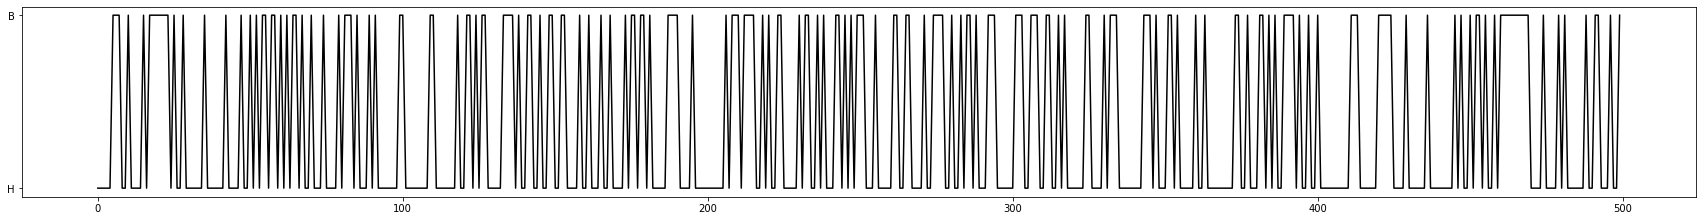

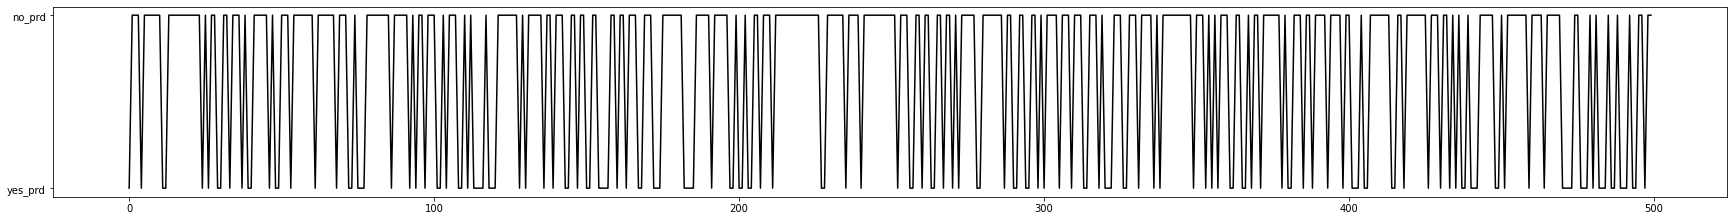

In [5]:
csv = pnd.read_csv('bank_software.csv')

alpha_data = nmp.ones((2, 2))
beta_data = nmp.array(((1, 3, 5), (2, 4, 6)))

alpha_data = alpha_data / nmp.sum(alpha_data, axis=1)
beta_data = beta_data / nmp.sum(beta_data, axis=1).reshape((-1, 1))

initial = nmp.array((0.5, 0.5))

BankOBJ = BankSoftWareModel()

alpha_data, beta_data = BankOBJ.matrix(csv['Customer'].values, alpha_data, beta_data, initial, 3000)
final_result = BankOBJ.possibility(csv['Customer'].values, alpha_data, beta_data, initial)
BankOBJ.create_plt(csv['System_failure'].values)
BankOBJ.create_plt(final_result)